In [46]:
from sklearn.datasets import fetch_openml
import numpy as np
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# The data (features) are stored in mnist.data
X = mnist.data

# The target labels are stored in mnist.target
y = mnist.target.astype(np.int64)

In [ ]:
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
random_state = 42


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=random_state)

Training on set 0
Training on set 10
Training on set 20
Training on set 30
Training on set 40
Training on set 50
Training on set 60
Training on set 70
Training on set 80
Training on set 90
Training on set 100
Training on set 110
Training on set 120
Training on set 130
Training on set 140
Training on set 150
Training on set 160
Training on set 170
Training on set 180
Training on set 190
Training on set 200
Training on set 210
Training on set 220
Training on set 230
Training on set 240
Training on set 250
Training on set 260
Training on set 270
Training on set 280
Training on set 290
Training on set 300
Training on set 310
Training on set 320
Training on set 330
Training on set 340
Training on set 350
Training on set 360
Training on set 370
Training on set 380
Training on set 390
Training on set 400
Training on set 410
Training on set 420
Training on set 430
Training on set 440
Training on set 450
Training on set 460
Training on set 470
Training on set 480
Training on set 490
Training on

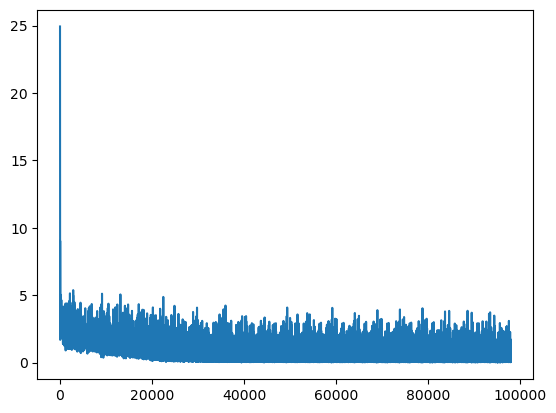

In [ ]:
import numpy as np
import pandas as pd

numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rng = np.random.default_rng(42)


class Linear:
    def __init__(self, n_in, n_out):

        self.W = np.random.normal(0, 1/np.sqrt(n_in), (n_out, n_in))
        self.b = np.zeros((n_out, 1))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, X):
        self.X = X
        return self.W @ self.X + self.b

    def backward(self, dZ):
        m = dZ.shape[1]
        self.dW = (dZ @ self.X.T) / m
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        dX = self.W.T @ dZ
        return dX


class Relu:
    def __init__(self):
        self.A = None

    def forward(self, Z):
        self.mask = (Z > 0).astype(Z.dtype)
        return Z * self.mask

    def backward(self, dA):
        return dA * self.mask


class Tanh:
    def __init__(self):
        self.A = None

    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A

    def backward(self, dA):
        return dA * (1 - self.A ** 2)


class Softmax:
    def __init__(self):
        self.A = None

    def forward(self, Z):
        Zs = Z - np.max(Z, axis=0, keepdims=True)
        expZ = np.exp(Zs)
        return expZ / np.sum(expZ, axis=0, keepdims=True)


def one_hot(y, num_classes):
    y = np.asarray(y, dtype=np.int64)          # shape (N,)
    oh = np.eye(num_classes, dtype=np.float32)[y]  # shape (N, C)
    return oh


class MLP:
    def __init__(self, n_in, n_h1, n_h2, n_out, act="relu"):
        self.l1 = Linear(n_in, n_h1)
        self.l2 = Linear(n_h1, n_h2)
        self.l3 = Linear(n_h2, n_out)
        self.act1 = Relu() if act == "relu" else Tanh()
        self.act2 = Relu() if act == "relu" else Tanh()
        self.out = None

    def forward(self, X):
        softmax = Softmax()
        z1 = self.l1.forward(X)
        a1 = self.act1.forward(z1)
        z2 = self.l2.forward(a1)
        a2 = self.act2.forward(z2)
        z3 = self.l3.forward(a2)
        a3 = softmax.forward(z3)
        self.out = a3

    def backward(self, Y):  # Y is correct answer in one_hot form, reshape to (n_h2, 1)
        n = Y.shape[0]
        dZ3 = self.out - Y
        dA3 = self.l3.backward(dZ3)
        dZ2 = self.act2.backward(dA3)
        dA2 = self.l2.backward(dZ2)
        dZ1 = self.act1.backward(dA2)
        _ = self.l1.backward(dZ1)

    def params_and_grads(self):
        return ([self.l1.W, self.l1.b, self.l2.W, self.l2.b, self.l3.W, self.l3.b], [self.l1.dW, self.l1.db, self.l2.dW, self.l2.db, self.l3.dW, self.l3.db])


class Adam:
    def __init__(self, params, lr=1e-3, b1=0.9, b2=0.999, eps=1e-8):
        self.lr, self.b1, self.b2, self.eps = lr, b1, b2, eps
        self.v = [np.zeros_like(p) for p in params]
        self.m = [np.zeros_like(p) for p in params]
        self.t = 0

    def step(self, params, grads):
        self.t += 1
        for i, (p, g) in enumerate(zip(params, grads)):
            self.v[i] = self.b2 * self.v[i] + (1-self.b2) * g ** 2
            self.m[i] = self.b1 * self.m[i] + (1-self.b1) * g
            v_hat = self.v[i] / (1 - self.b2 ** self.t)
            m_hat = self.m[i] / (1 - self.b1 ** self.t)
            p -= self.lr * m_hat/(np.sqrt(v_hat) + self.eps)


i = 0
model = MLP(784, 10, 10, 10)
params, _ = model.params_and_grads()
opt = Adam(params)
batch_size = 10


def ce_loss_from_probs(P, Y):  # both (C,N)
    eps = 1e-12
    return -np.mean(np.log(np.sum(P*Y, axis=0) + eps))


class Verbose:
    def trial_verbose(i):
        print(f"Training on set {i}")


losses = []
for epoch in range(20):
    rng = np.random.default_rng(42)
    idx = rng.permutation(len(X_train))
    for start in range(0, len(X_train), batch_size):
        Verbose.trial_verbose(start)
        b = idx[start:start+batch_size]
        Xb = X_train[b].reshape(-1, 784).T    # (784, B)
        yb = y_train[b]
        model.forward(Xb)
        Yb = one_hot(yb, 10).T                # (10, B)
        losses.append(ce_loss_from_probs(model.out, Yb))
        model.backward(Yb)
        params, grads = model.params_and_grads()
        opt.step(params, grads)


plt.plot(losses)

Prediction: 8
Answer: 8
Prediction: 7
Answer: 7
Prediction: 7
Answer: 9
Prediction: 9
Answer: 9
Prediction: 3
Answer: 3
Prediction: 3
Answer: 9
Prediction: 1
Answer: 1
Prediction: 1
Answer: 1
Prediction: 9
Answer: 9
Prediction: 4
Answer: 4


/var/folders/qy/v8xq2pb11n5c02fypwnbyv_80000gn/T/ipykernel_35716/2260025814.py:10: DeprecationWarning: This function is deprecated. Please call randint(1, 21000 + 1) instead
  test_prediction(np.random.random_integers(1, 21000, 10))


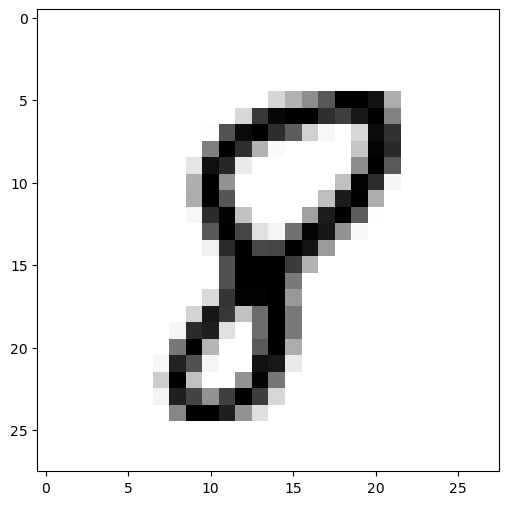

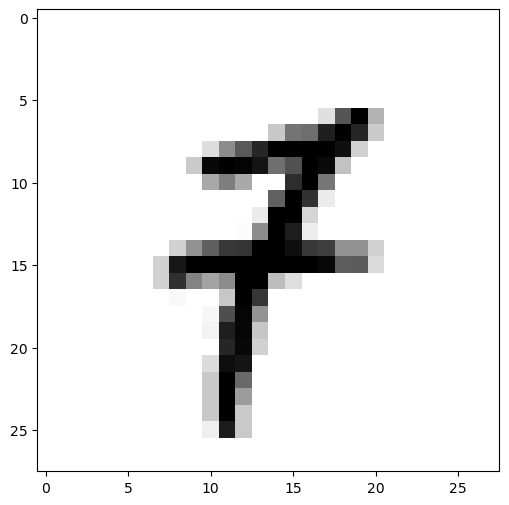

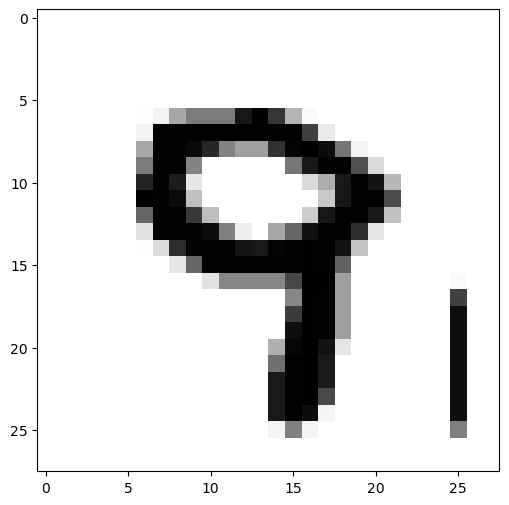

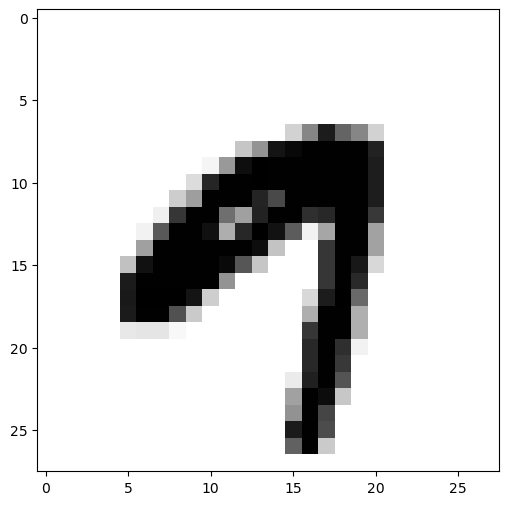

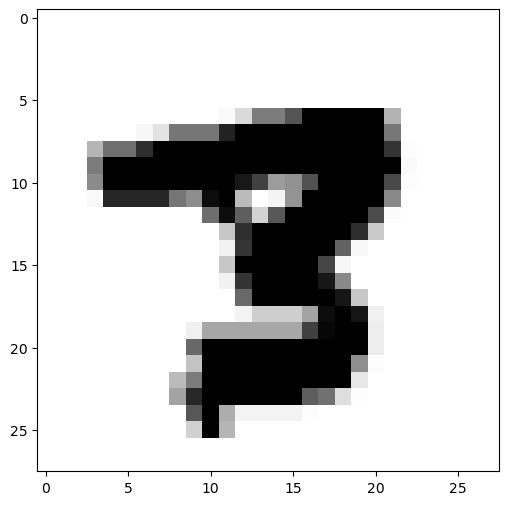

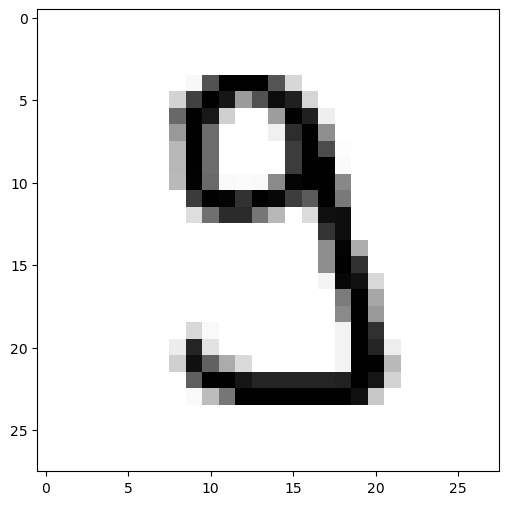

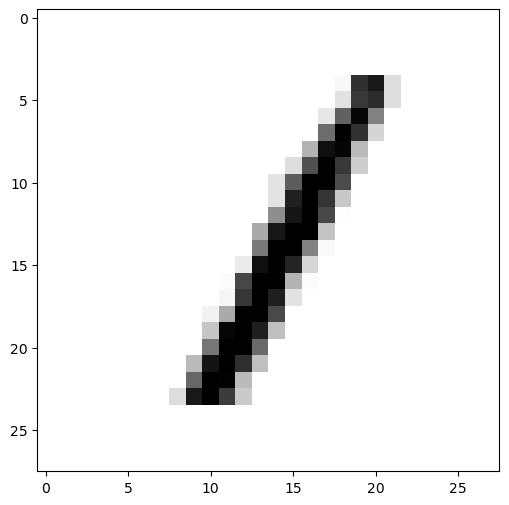

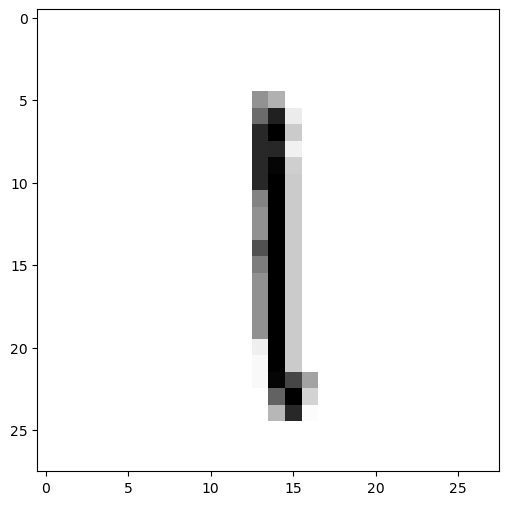

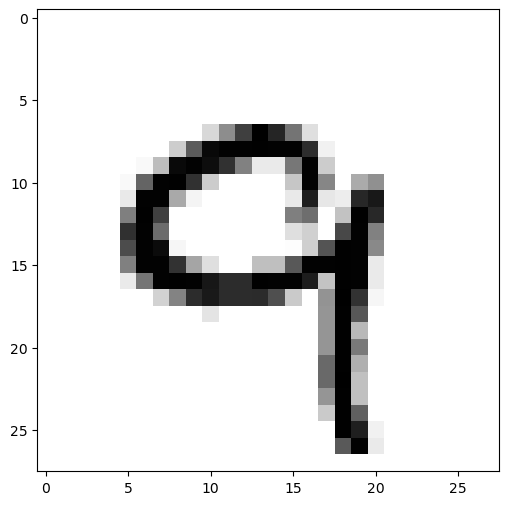

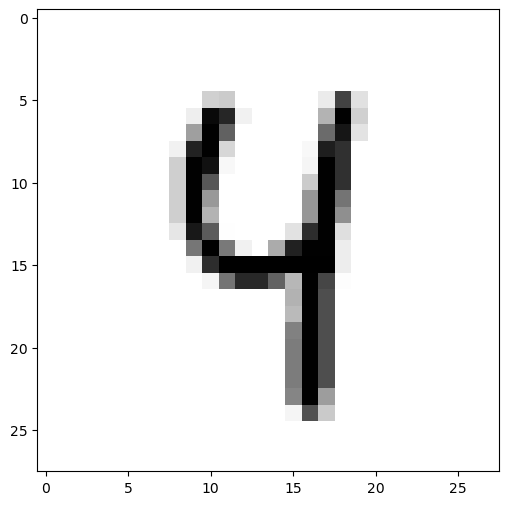

In [ ]:
def test_prediction(set):
    for i in set:
        model.forward(X_test[i].reshape(-1, 1))
        print(f"Prediction: {numbers[np.argmax(model.out)]}")
        print(f"Answer: {y_test[i]}")
        plt.figure(figsize=(12, 6))
        plt.imshow((X_test[i].reshape(28, 28)),
                   cmap=plt.cm.gray_r, interpolation='nearest')


test_prediction(np.random.random_integers(1, 21000, 10))

In [ ]:
def one_hot(y, num_classes):
    y = np.asarray(y, dtype=np.int64)          # shape (N,)
    oh = np.eye(num_classes, dtype=np.float32)[y]  # shape (N, C)
    return oh


one_hot([3, 4, 5], 10)

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)